In [1]:
%matplotlib notebook
import mdp
import mdp_worlds
import utils
import numpy as np
import random 
import bayesian_irl
import plot_gridworld as pg
import matplotlib.pyplot as plt

[-0.11043153 -0.99388373]
Cliff world
Optimal Policy
v	<	<	<	<	
v	v	v	v	v	
>	>	>	>	.	
reward
-0.11	-0.11	-0.11	-0.11	-0.11	
-0.11	-0.99	-0.99	-0.99	-0.99	
-0.11	-0.11	-0.11	-0.11	-0.11	
features
0 	0 	0 	0 	0 	
0 	1 	1 	1 	1 	
0 	0 	0 	0 	0 	
demo 0 [(1, 0), (0, 3), (5, 3), (10, 1), (11, 1), (12, 1), (13, 1), (14, None)]
demonstration
[(11, 1), (12, 1), (13, 1), (5, 3), (0, 3), (10, 1), (14, None), (1, 0)]


<IPython.core.display.Javascript object>


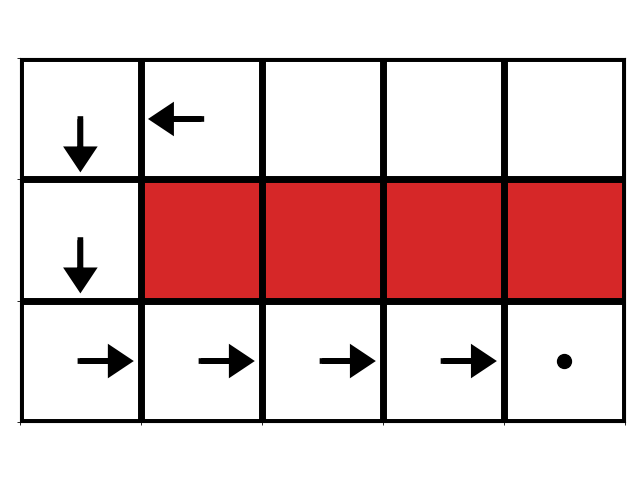

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]
0
w_map [ 0.49935207 -0.86639916] loglik = -497.2751
2
w_map [ 0.40743223 -0.91323545] loglik = -407.1845
5
w_map [ 0.31274563 -0.94983692] loglik = -314.3822
6
w_map [ 0.2456797  -0.96935106] loglik = -248.6509
7
w_map [ 0.03248832 -0.99947212] loglik = -39.7021
8
w_map [-0.08945171 -0.99599116] loglik = -3.8111
17
w_map [-0.26399584 -0.96452382] loglik = -0.9789
175
w_map [-0.26340902 -0.96468424] loglik = -0.9789
519
w_map [-0.26342521 -0.96467982] loglik = -0.9789
w_map [-0.26342521 -0.96467982] loglik -0.9788859472120066
accepted/total = 759/2000 = 0.3795
[[ 0.49935207 -0.86639916]
 [ 0.49935207 -0.86639916]
 [ 0.40743223 -0.91323545]
 ...
 [-0.10369445 -0.9946092 ]
 [-0.26825944 -0.9633467 ]
 [-0.26825944 -0.9633467 ]]
MAP
map_weights [-0.26342521 -0.96467982]
map reward
-0.26	-0.26	-0.26	-0.26	-0.26	
-0.26	-0.96	-0.96	-0.96	-0.96	
-0.26	-0.26	-0.26	-0.26	-0.26	
Map policy
v	<	>	>	v	
v	v	v	v	v	
>	>	>	>	.	
MEAN
mean_weights [-0.2

<IPython.core.display.Javascript object>


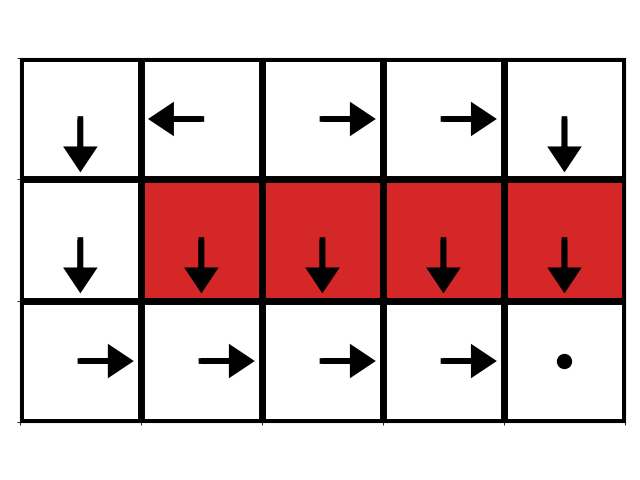

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]


In [2]:
#used this to plot the diagrams in the paper currently.

init_seed = 1#4 + 10
np.random.seed(init_seed)
random.seed(init_seed)

slip_prob = 0.3
demo_horizon = 10
num_demos = 1

###Bayesian IRL
beta = 10.0
step_stdev = 0.2
burn = 500
skip = 5
num_samples = 2000
mcmc_norm = "l2"
likelihood = "birl"

mdp_env = mdp_worlds.lava_ambiguous_corridor()
opt_sa = mdp.solve_mdp_lp(mdp_env)


print("Cliff world")
print("Optimal Policy")
utils.print_policy_from_occupancies(opt_sa, mdp_env)
print("reward")
utils.print_as_grid(mdp_env.r_s, mdp_env)
print("features")
utils.display_onehot_state_features(mdp_env)

init_demo_state = 1#mdp_env.num_cols * (mdp_env.num_rows - 1)
traj_demonstrations = []
demo_set = set()
for d in range(num_demos):
    # np.random.seed(init_seed + d)
    # random.seed(init_seed + d)
    s = init_demo_state #mdp_env.init_states[0] # only one initial state
    demo = utils.rollout_from_usa(s, demo_horizon, opt_sa, mdp_env)
    print("demo", d, demo)
    traj_demonstrations.append(demo)
    for s_a in demo:
        demo_set.add(s_a)
demonstrations = list(demo_set)
print("demonstration")
print(demonstrations)

state_feature_list = [tuple(fs) for fs in mdp_env.state_features]
pg.get_policy_string_from_trajectory(traj_demonstrations[0], state_feature_list, mdp_env, filename="./figs/lava_corridor/demo_lava_world.pdf")


#Now let's run Bayesian IRL on this demo


birl = bayesian_irl.BayesianIRL(mdp_env, beta, step_stdev, debug=False, mcmc_norm=mcmc_norm, likelihood=likelihood)

map_w, map_u, r_chain, u_chain = birl.sample_posterior(demonstrations, num_samples, True)
print(r_chain)




r_chain_burned = r_chain[burn::skip]

u_expert = utils.u_sa_from_demos(traj_demonstrations, mdp_env)
expert_returns = np.sort(np.dot(r_chain_burned, u_expert))






#get the r_sa matrix from the posterior 
Rsa = utils.convert_w_to_rsa(r_chain_burned, mdp_env)


print("MAP")
print("map_weights", map_w)
map_r = np.dot(mdp_env.state_features, map_w)
print("map reward")
utils.print_as_grid(map_r, mdp_env)
print("Map policy")
utils.print_policy_from_occupancies(map_u, mdp_env)
map_returns = np.sort(np.dot(Rsa, map_u))


print("MEAN")
mean_w = np.mean(r_chain_burned, axis=0)
print("mean_weights", mean_w)
mean_r = np.dot(mdp_env.state_features, mean_w)
mean_r_sa = mdp_env.transform_to_R_sa(mean_w)
mean_u_sa = mdp.solve_mdp_lp(mdp_env, reward_sa=mean_r_sa) #use optional argument to replace standard rewards with sample
print('mean reward')
utils.print_as_grid(mean_r, mdp_env)
print("mean policy")
utils.print_policy_from_occupancies(mean_u_sa, mdp_env)

pi = utils.get_policy_string_from_occupancies(mean_u_sa, mdp_env)
state_feature_list = [tuple(fs) for fs in mdp_env.state_features]
pg.plot_optimal_policy_lists(pi, state_feature_list, mdp_env.num_rows, mdp_env.num_cols, "./figs/lava_corridor/mean.pdf")
    

mean_returns = np.sort(np.dot(Rsa, mean_u_sa))


ALPHA 0.95 LAMBDA 0.0
------ Robust Solution ---------
Policy for lambda=0.0 and alpha=0.95
v	>	>	>	v	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


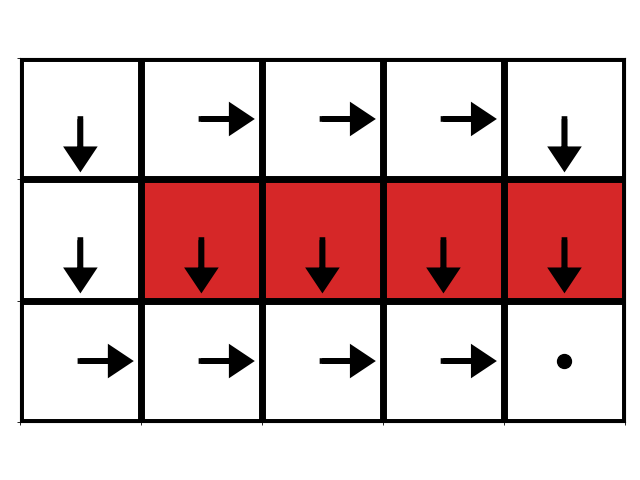

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]
------ Regret Solution ---------
Policy for lambda=0.0 and alpha=0.95
v	<	<	<	<	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


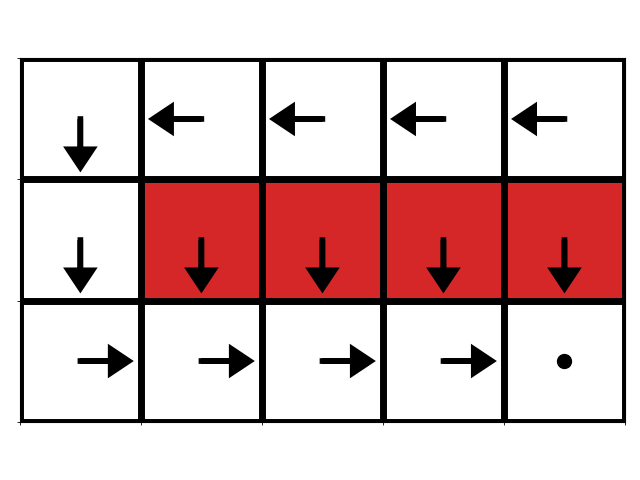

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]

ALPHA 0.95 LAMBDA 0.1
------ Robust Solution ---------
Policy for lambda=0.1 and alpha=0.95
v	>	>	>	v	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


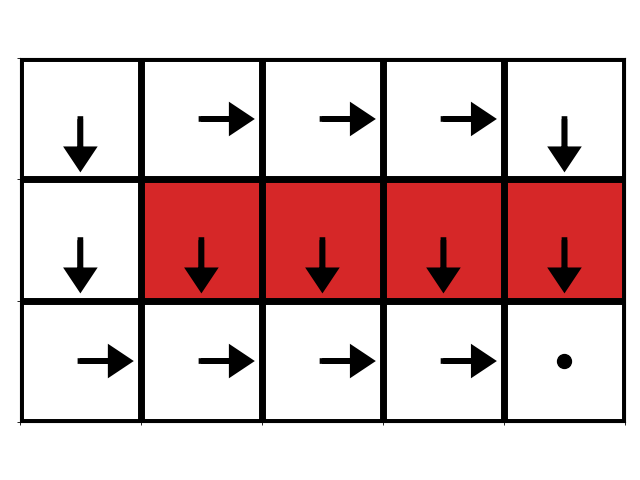

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]
------ Regret Solution ---------
Policy for lambda=0.1 and alpha=0.95
v	<	<	<	v	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


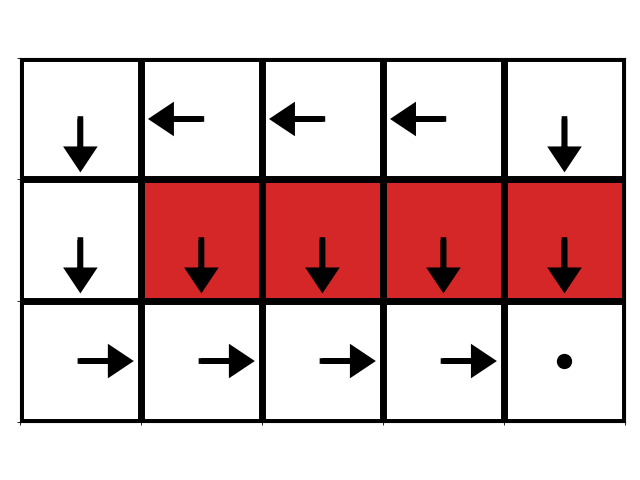

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]

ALPHA 0.95 LAMBDA 0.3
------ Robust Solution ---------
Policy for lambda=0.3 and alpha=0.95
v	>	>	>	v	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


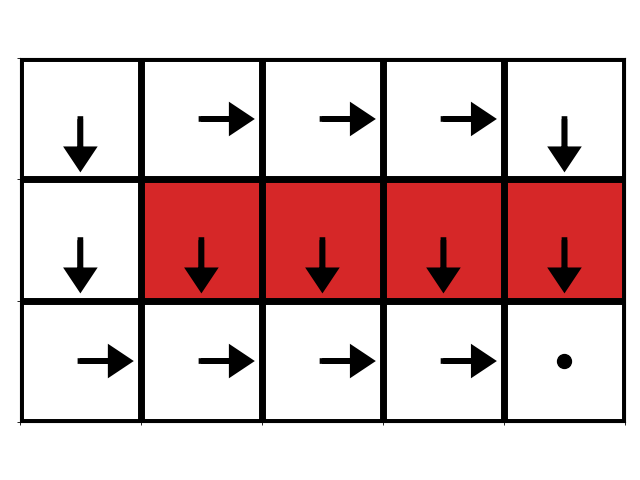

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]
------ Regret Solution ---------
Policy for lambda=0.3 and alpha=0.95
v	<	<	>	v	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


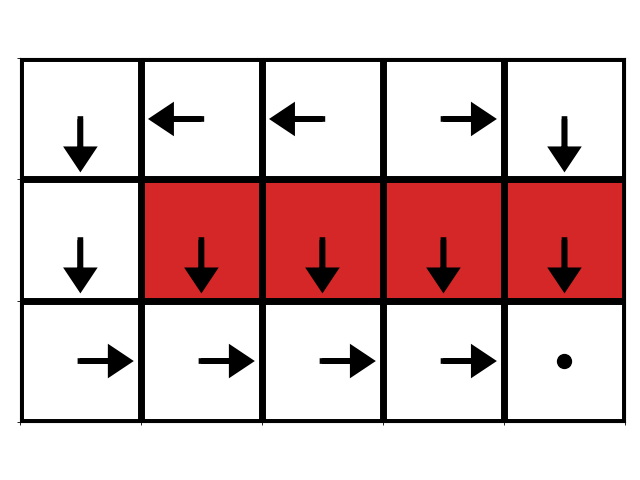

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]

ALPHA 0.95 LAMBDA 0.5
------ Robust Solution ---------
Policy for lambda=0.5 and alpha=0.95
v	<	>	>	v	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


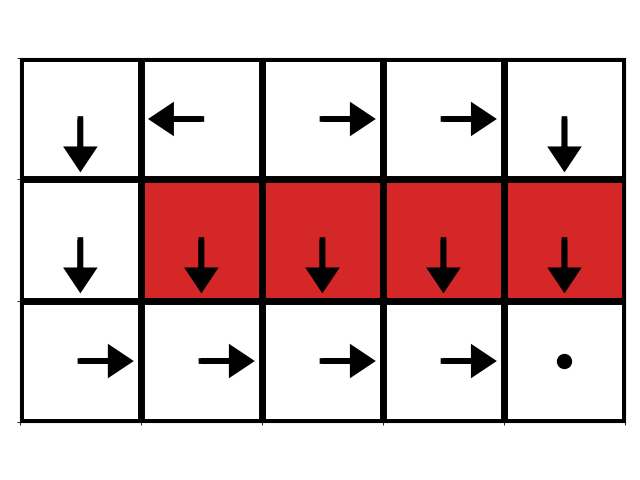

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]
------ Regret Solution ---------
Policy for lambda=0.5 and alpha=0.95
v	<	<	>	v	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


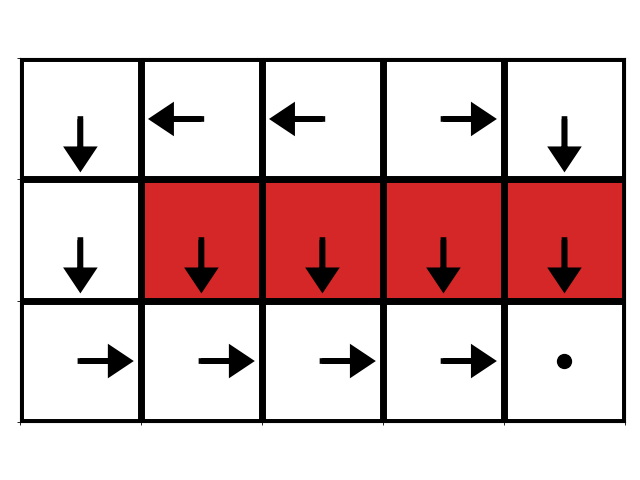

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]

ALPHA 0.95 LAMBDA 0.8
------ Robust Solution ---------
Policy for lambda=0.8 and alpha=0.95
v	<	>	>	v	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


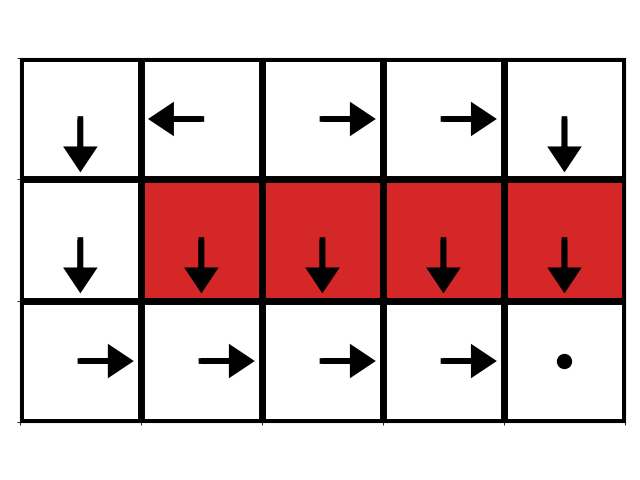

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]
------ Regret Solution ---------
Policy for lambda=0.8 and alpha=0.95
v	<	>	>	v	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


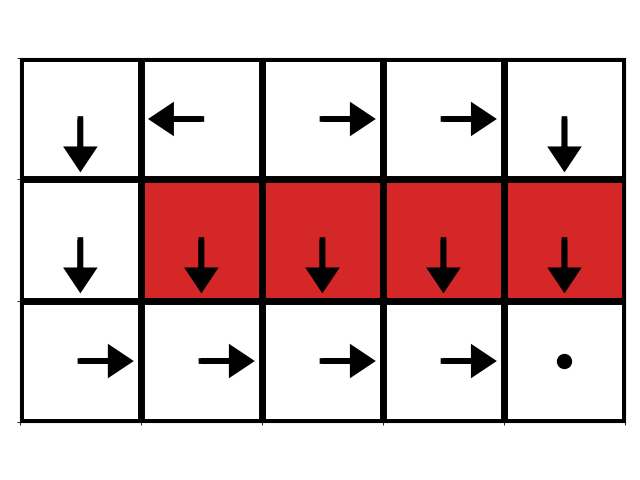

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]

ALPHA 0.95 LAMBDA 1.0
------ Robust Solution ---------
Policy for lambda=1.0 and alpha=0.95
v	<	>	>	v	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


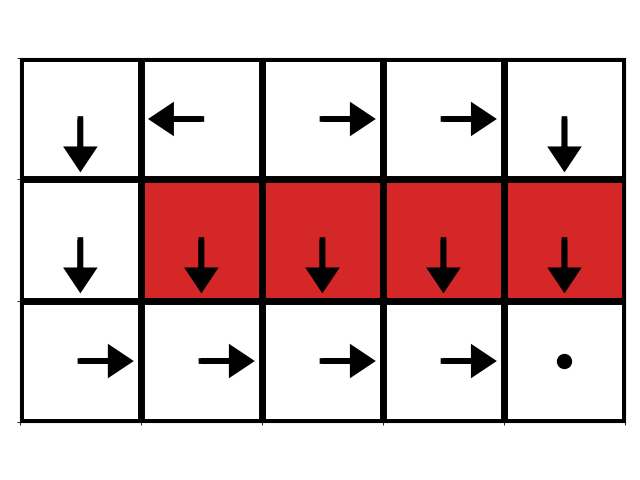

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]
------ Regret Solution ---------
Policy for lambda=1.0 and alpha=0.95
v	<	>	>	v	
v	v	v	v	v	
>	>	>	>	.	


<IPython.core.display.Javascript object>


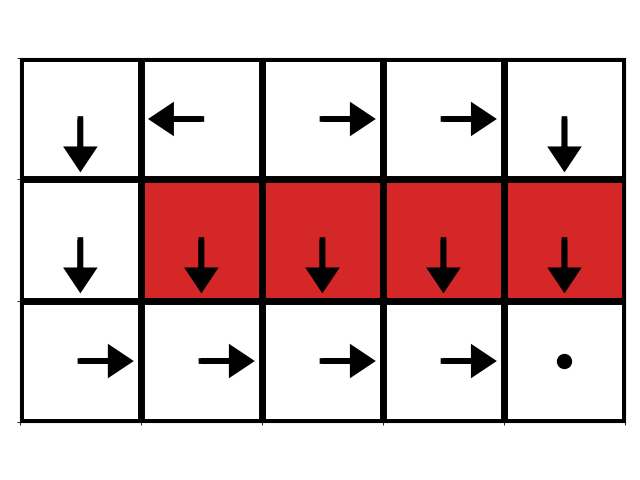

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]


In [3]:
#Now let's see what CVaR optimization does.
lambdas = [0., 0.1, 0.3, 0.5, 0.8, 1.0]
alpha = 0.95
for lamda in lambdas:
    print()
    print("ALPHA", alpha, "LAMBDA", lamda)

    debug = False
    

    n = r_chain_burned.shape[0]
    posterior_probs = np.ones(n) / n  #uniform dist since samples from MCMC

    
    print("------ Robust Solution ---------")
    u_expert = np.zeros(mdp_env.num_actions * mdp_env.num_states)
    robust_opt_usa, cvar_value, exp_ret = mdp.solve_max_cvar_policy(mdp_env, u_expert, r_chain_burned.transpose(), posterior_probs, alpha, debug, lamda)
    #utils.print_stochastic_policy_action_probs(cvar_opt_usa, mdp_env_A)
    print("Policy for lambda={} and alpha={}".format(lamda, alpha))
    utils.print_policy_from_occupancies(robust_opt_usa, mdp_env)

#     robust_returns = np.sort(np.dot(Rsa, robust_opt_usa))


    pi = utils.get_policy_string_from_occupancies(robust_opt_usa, mdp_env)
    state_feature_list = [tuple(fs) for fs in mdp_env.state_features]
    pg.plot_optimal_policy_lists(pi, state_feature_list, mdp_env.num_rows, mdp_env.num_cols, "./figs/lava_corridor/robust_alpha" + str(alpha) + "lambda" + str(lamda) + ".pdf")
    
    

    print("------ Regret Solution ---------")
    traj_demonstrations = [demonstrations]
    u_expert = utils.u_sa_from_demos(traj_demonstrations, mdp_env)
    
    regret_opt_usa, cvar_value, exp_ret = mdp.solve_max_cvar_policy(mdp_env, u_expert, r_chain_burned.transpose(), posterior_probs, alpha, debug, lamda)
    #utils.print_stochastic_policy_action_probs(cvar_opt_usa, mdp_env_A)
    print("Policy for lambda={} and alpha={}".format(lamda, alpha))
    utils.print_policy_from_occupancies(regret_opt_usa, mdp_env)



    pi = utils.get_policy_string_from_occupancies(regret_opt_usa, mdp_env)
    state_feature_list = [tuple(fs) for fs in mdp_env.state_features]
    pg.plot_optimal_policy_lists(pi, state_feature_list, mdp_env.num_rows, mdp_env.num_cols, "./figs/lava_corridor/regret_alpha" + str(alpha) + "lambda" + str(lamda) + ".pdf")

lpal policy
v	<	<	<	<	
v	v	v	v	v	
>	>	>	>	.	
state 0: < = 0.154, > = 0.111, ^ = 0.154, v = 0.580, 
state 1: < = 0.659, > = 0.141, ^ = 0.199, v = 0.000, 
state 2: < = 0.611, > = 0.158, ^ = 0.231, v = 0.000, 
state 3: < = 0.526, > = 0.206, ^ = 0.269, v = 0.000, 
state 4: < = 0.410, > = 0.295, ^ = 0.295, v = 0.000, 
state 5: < = 0.166, > = 0.000, ^ = 0.108, v = 0.726, 
state 6: < = 0.306, > = 0.000, ^ = 0.211, v = 0.483, 
state 7: < = 0.000, > = 0.000, ^ = 0.235, v = 0.765, 
state 8: < = 0.000, > = 0.000, ^ = 0.211, v = 0.789, 
state 9: < = 0.000, > = 0.000, ^ = 0.177, v = 0.823, 
state 10: < = 0.134, > = 0.657, ^ = 0.075, v = 0.134, 
state 11: < = 0.077, > = 0.786, ^ = 0.000, v = 0.137, 
state 12: < = 0.071, > = 0.809, ^ = 0.000, v = 0.121, 
state 13: < = 0.064, > = 0.821, ^ = 0.000, v = 0.115, 
state 14: < = 0.250, > = 0.250, ^ = 0.250, v = 0.250, 


/home/dsbrown/Code/broil/mdp.py:784: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  sol = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_leq, b_ub=b_geq, bounds=(None, None))
/home/dsbrown/Code/broil/mdp.py:784: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  sol = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_leq, b_ub=b_geq, bounds=(None, None))
/home/dsbrown/anaconda3/envs/broil/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:116: LinAlgWarning: Ill-conditioned matrix (rcond=1.55916e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/dsbrown/Code/broil/mdp.py:784: OptimizeWa

<IPython.core.display.Javascript object>


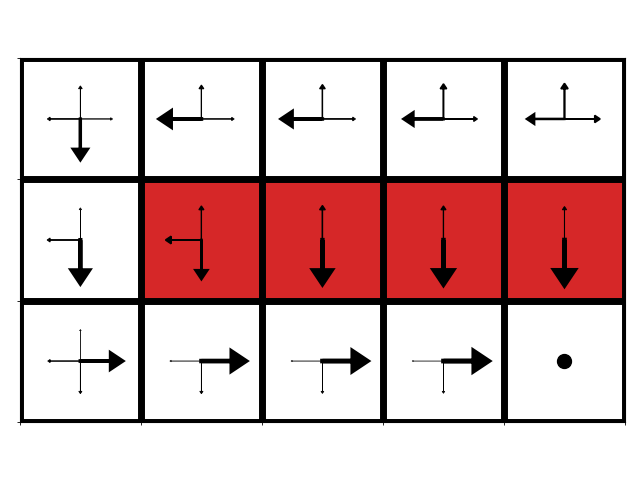

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]


In [4]:
#LPAL solution
u_expert = utils.u_sa_from_demos(traj_demonstrations, mdp_env)
lpal_usa = mdp.solve_lpal_policy(mdp_env, u_expert)
#utils.print_stochastic_policy_action_probs(cvar_opt_usa, mdp_env_A)
print("lpal policy")
utils.print_policy_from_occupancies(lpal_usa, mdp_env)
utils.print_stochastic_policy_action_probs(lpal_usa, mdp_env)
pi_dict = utils.get_stoch_policy_string_dictionary_from_occupancies(lpal_usa, mdp_env)
state_feature_list = [tuple(fs) for fs in mdp_env.state_features]
pg.plot_optimal_policy_stochastic(pi_dict, state_feature_list, mdp_env.num_rows, mdp_env.num_cols, "./figs/lava_corridor/lpal.pdf")

--------epoch 0 ---------
[0.84269082 1.03428666 1.29082016 1.42030662 1.35767738 0.84602297
 0.99533319 1.14902138 1.04487628 0.68813592 0.84430512 0.95474983
 0.96487781 0.56689367 0.06666695 0.06666693]
grad [-2.18929797 -3.87736678]
r [-0.49167303 -0.8707799 ]
--------epoch 1 ---------
[0.06771459 0.07264329 0.1215462  0.1479909  0.1416553  0.12891364
 0.08759946 0.10905263 0.1430914  0.20940267 0.19465192 0.34665538
 0.52123055 0.72934713 1.         1.        ]
grad [ 4.5276511  -0.54914616]
r [-0.45392104 -0.89104191]
--------epoch 2 ---------
[0.06831658 0.07059719 0.12022078 0.1475347  0.14263271 0.13180775
 0.08570475 0.10739809 0.1410249  0.20798858 0.19974598 0.35055011
 0.5251806  0.733292   1.         1.        ]
grad [ 4.5101216  -0.54211631]
r [-0.41492691 -0.90985475]
--------epoch 3 ---------
[0.06955872 0.06962763 0.11954877 0.14761058 0.14417684 0.13440395
 0.08450319 0.10633708 0.13967523 0.20721261 0.20455188 0.35432748
 0.52944643 0.73797487 1.         1.        ]

<IPython.core.display.Javascript object>


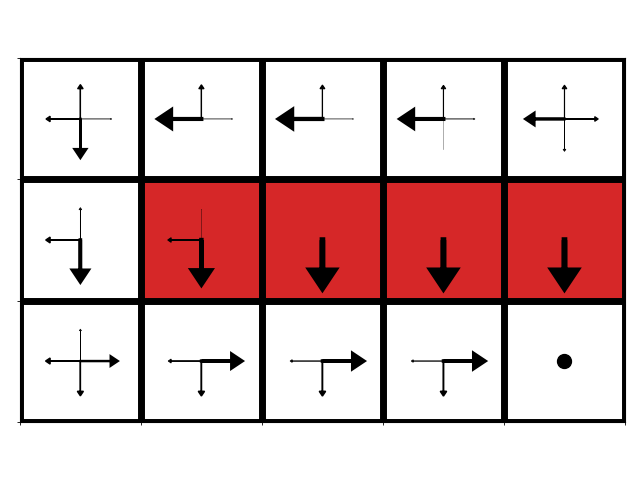

[[1, 1, 1, 1, 1], [1, 2, 2, 2, 2], [1, 1, 1, 1, 1]]


In [5]:
import maxent
#just keep states in traj_demos
maxent_demos = []
for d in traj_demonstrations:
    #add only states to demos
    demo = []
    for s,a in d:
        demo.append(s)
    maxent_demos.append(demo)
maxent_usa, r_weights, maxent_pi = maxent.calc_max_ent_u_sa(mdp_env, maxent_demos)
print("max ent policy")
utils.print_policy_from_occupancies(maxent_usa, mdp_env)
utils.print_stochastic_policy_action_probs(maxent_usa, mdp_env)
pi_dict = utils.get_stoch_policy_string_dictionary_from_occupancies(maxent_usa, mdp_env)
state_feature_list = [tuple(fs) for fs in mdp_env.state_features]
pg.plot_optimal_policy_stochastic(pi_dict, state_feature_list, mdp_env.num_rows, mdp_env.num_cols, "./figs/lava_corridor/maxent.pdf")

In [6]:
#Now let's see what CVaR optimization does.
lambdas = [0.]
alpha = 0.95
for lamda in lambdas:
    print()
    print("ALPHA", alpha, "LAMBDA", lamda)

    debug = False
    

    n = r_chain_burned.shape[0]
    posterior_probs = np.ones(n) / n  #uniform dist since samples from MCMC

    
    print("------ Robust Solution ---------")
    u_expert = np.zeros(mdp_env.num_actions * mdp_env.num_states)
    robust_opt_usa, cvar_value, exp_ret = mdp.solve_max_cvar_policy(mdp_env, u_expert, r_chain_burned.transpose(), posterior_probs, alpha, debug, lamda)
    #utils.print_stochastic_policy_action_probs(cvar_opt_usa, mdp_env_A)
    print("Policy for lambda={} and alpha={}".format(lamda, alpha))
    utils.print_policy_from_occupancies(robust_opt_usa, mdp_env)

    robust_returns = np.sort(np.dot(Rsa, robust_opt_usa))

    
    

    print("------ Regret Solution ---------")
    traj_demonstrations = [demonstrations]
    u_expert = utils.u_sa_from_demos(traj_demonstrations, mdp_env)
    
    regret_opt_usa, cvar_value, exp_ret = mdp.solve_max_cvar_policy(mdp_env, u_expert, r_chain_burned.transpose(), posterior_probs, alpha, debug, lamda)
    #utils.print_stochastic_policy_action_probs(cvar_opt_usa, mdp_env_A)
    print("Policy for lambda={} and alpha={}".format(lamda, alpha))
    utils.print_policy_from_occupancies(regret_opt_usa, mdp_env)

    regret_returns = np.sort(np.dot(Rsa, regret_opt_usa))




ALPHA 0.95 LAMBDA 0.0
------ Robust Solution ---------
Policy for lambda=0.0 and alpha=0.95
v	>	>	>	v	
v	v	v	v	v	
>	>	>	>	.	
------ Regret Solution ---------
Policy for lambda=0.0 and alpha=0.95
v	<	<	<	<	
v	v	v	v	v	
>	>	>	>	.	


In [7]:
lpal_returns = np.sort(np.dot(Rsa, lpal_usa))
maxent_returns = np.sort(np.dot(Rsa, maxent_usa))
mean_returns = np.sort(np.dot(Rsa, mean_u_sa))

<IPython.core.display.Javascript object>


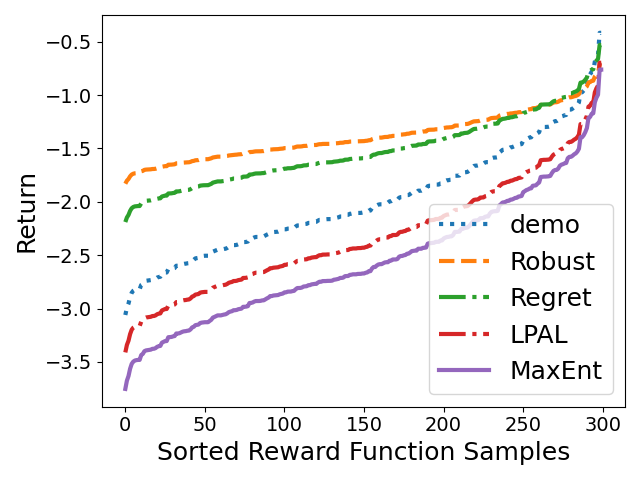

In [8]:
plt.figure(20)
plt.plot(expert_returns, ':',label='demo',linewidth=3)
plt.plot(robust_returns,'--', label='Robust',linewidth=3)
plt.plot(regret_returns, '-.',label='Regret',linewidth=3)
plt.plot(lpal_returns,'-.',label="LPAL", linewidth=3)
plt.plot(maxent_returns,'-',label="MaxEnt", linewidth=3)
plt.legend(fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Return", fontsize=18)
plt.xlabel("Sorted Reward Function Samples", fontsize=18)
# plt.show()
plt.tight_layout()
plt.savefig("./figs/lava_corridor/robust_vs_baseline.pdf")

<IPython.core.display.Javascript object>


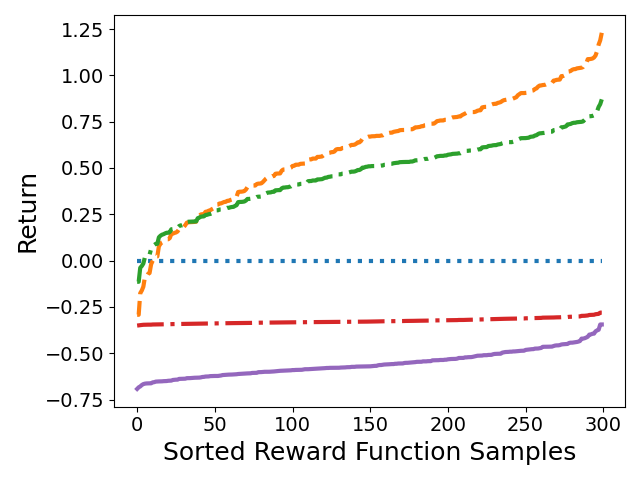

In [9]:
#plot the baseline regret lines with respect to expert
expert_returns = np.dot(r_chain_burned, u_expert)

robust_returns_expert = np.sort(np.dot(Rsa, robust_opt_usa) - expert_returns)
regret_returns_expert = np.sort(np.dot(Rsa, regret_opt_usa) - expert_returns)
maxent_returns_expert = np.sort(np.dot(Rsa, maxent_usa) - expert_returns)
lpal_returns_expert = np.sort(np.dot(Rsa, lpal_usa) - expert_returns)


plt.figure(21)
plt.plot(expert_returns-expert_returns, ':',label='demo',linewidth=3)
plt.plot(robust_returns_expert,'--', label='Robust',linewidth=3)
plt.plot(regret_returns_expert, '-.',label='Regret',linewidth=3)
plt.plot(lpal_returns_expert,'-.',label="LPAL", linewidth=3)
plt.plot(maxent_returns_expert,'-',label="MaxEnt", linewidth=3)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Return", fontsize=18)
plt.xlabel("Sorted Reward Function Samples", fontsize=18)
plt.tight_layout()
plt.savefig("./figs/lava_corridor/robust_vs_baseline_regretnormalized.pdf")

In [10]:
import generate_efficient_frontier

In [11]:
#Let's try and plot the efficient frontier for the baseline regret policy

In [12]:
lambda_range = [0., 0.1,0.2, 0.3,0.4, 0.5,0.6,0.7, 0.8,0.9,0.95,0.99]
u_expert = utils.u_sa_from_demos(traj_demonstrations, mdp_env)


cvar_rets = generate_efficient_frontier.calc_frontier(mdp_env, u_expert, r_chain_burned.transpose(), posterior_probs, lambda_range, alpha, debug=False)

cvar_rets_array = np.array(cvar_rets)
print(cvar_rets_array)


Policy for lambda=0.0 and alpha=0.95
v	<	<	<	<	
v	v	v	v	v	
>	>	>	>	.	
stochastic policy
state 0: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 1: < = 1.000, > = 0.000, ^ = 0.000, v = 0.000, 
state 2: < = 1.000, > = 0.000, ^ = 0.000, v = 0.000, 
state 3: < = 1.000, > = 0.000, ^ = 0.000, v = 0.000, 
state 4: < = 1.000, > = 0.000, ^ = 0.000, v = 0.000, 
state 5: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 6: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 7: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 8: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 9: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 10: < = 0.000, > = 1.000, ^ = 0.000, v = 0.000, 
state 11: < = 0.000, > = 1.000, ^ = 0.000, v = 0.000, 
state 12: < = 0.000, > = 1.000, ^ = 0.000, v = 0.000, 
state 13: < = 0.000, > = 1.000, ^ = 0.000, v = 0.000, 
state 14: < = 0.250, > = 0.250, ^ = 0.250, v = 0.250, 
CVaR of policy = 0.021143715312322245
Expected return of policy = 0.46887756024764093
Policy for 

Policy for lambda=0.9 and alpha=0.95
v	<	>	>	v	
v	v	v	v	v	
>	>	>	>	.	
stochastic policy
state 0: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 1: < = 1.000, > = 0.000, ^ = 0.000, v = 0.000, 
state 2: < = 0.000, > = 1.000, ^ = 0.000, v = 0.000, 
state 3: < = 0.000, > = 1.000, ^ = 0.000, v = 0.000, 
state 4: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 5: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 6: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 7: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 8: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 9: < = 0.000, > = 0.000, ^ = 0.000, v = 1.000, 
state 10: < = 0.000, > = 1.000, ^ = 0.000, v = 0.000, 
state 11: < = 0.000, > = 1.000, ^ = 0.000, v = 0.000, 
state 12: < = 0.000, > = 1.000, ^ = 0.000, v = 0.000, 
state 13: < = 0.000, > = 1.000, ^ = 0.000, v = 0.000, 
state 14: < = 0.250, > = 0.250, ^ = 0.250, v = 0.250, 
CVaR of policy = -0.039523664530677766
Expected return of policy = 0.6203659156902475
Policy for 

<IPython.core.display.Javascript object>


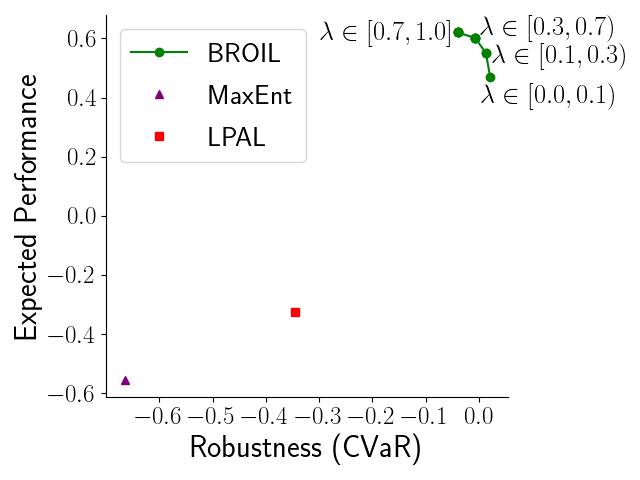

(60, 300)
(60,)
(300, 2)
(2,)
(60, 300)
(60,)
(300, 2)
(2,)


In [13]:
#robust version
u_expert = utils.u_sa_from_demos(traj_demonstrations, mdp_env)        
#input()
plt.figure()
ax = plt.subplot(111)
#plt.title(r"$\alpha = {}$".format(alpha))
ax.plot(cvar_rets_array[:,0], cvar_rets_array[:,1], '-o',label="BROIL",color='green')
#go through and label the points in the figure with the corresponding lambda values
unique_pts_lambdas = []
unique_pts = []
for i,pt in enumerate(cvar_rets_array):
    unique = True
    for upt in unique_pts:
        if np.linalg.norm(upt - pt) < 0.00001:
            unique = False
            break
    if unique:
        unique_pts_lambdas.append((pt[0], pt[1], lambda_range[i]))
        unique_pts.append(np.array(pt))
#calculate offset
offsetx = (np.max(cvar_rets_array[:,0]) - np.min(cvar_rets_array[:,0]))/30
offsety = (np.max(cvar_rets_array[:,1]) - np.min(cvar_rets_array[:,1]))/17
#print(offsetx)
#input()
for i,pt in enumerate(unique_pts_lambdas):
    if i in [0]:
        ax.text(pt[0]- 9*offsetx, pt[1] - 10*offsety, r"$\lambda \in [{},{})$".format(str(pt[2]), unique_pts_lambdas[i+1][2]), fontsize=19,  fontweight='bold')
    elif i in [1]:
        ax.text(pt[0] + 5.5*offsetx, pt[1] - 4*offsety , r"$\lambda \in [{},{})$".format(str(pt[2]), unique_pts_lambdas[i+1][2]), fontsize=19,  fontweight='bold')
    elif i in [2]:
        ax.text(pt[0] + 5*offsetx,pt[1] + 1*offsety  , r"$\lambda \in [{},{})$".format(str(pt[2]), unique_pts_lambdas[i+1][2]), fontsize=19,  fontweight='bold')
    elif i in [3]:
        ax.text(pt[0]- 128*offsetx, pt[1] - 3*offsety, r"$\lambda \in [{},1.0]$".format(str(pt[2]),1), fontsize=19,  fontweight='bold')
    else:
        ax.text(pt[0]+2*offsetx, pt[1] + 1.5*offsety, r"$\lambda = {}$".format(str(pt[2])), fontsize=19,  fontweight='bold')


#plot Maxent and LPAL

cvar_maxent, expret_maxent = mdp.solve_cvar_expret_fixed_policy(mdp_env, maxent_usa, u_expert, r_chain_burned.transpose(), posterior_probs, alpha, debug=False)
ax.plot(cvar_maxent, expret_maxent, '^',label='MaxEnt', color='purple')

#plot LPAL
cvar_lpal, expret_lpal = mdp.solve_cvar_expret_fixed_policy(mdp_env, lpal_usa, u_expert, r_chain_burned.transpose(), posterior_probs, alpha, debug=False)
ax.plot(cvar_lpal, expret_lpal, 's',label='LPAL', color='red')




plt.xticks(fontsize=18) 
plt.yticks(fontsize=18) 
plt.xlabel("Robustness (CVaR)", fontsize=22)
plt.ylabel("Expected Performance", fontsize=22)

plt.legend(loc='best', fontsize=20)
plt.tight_layout()
#plt.show()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("./figs/lava_corridor/efficient_frontier.pdf")

plt.show()

